In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative

In [3]:
plt.style.use('cyberpunk')
# mplcyberpunk.make_lines_glow()

In [4]:
#real solutions

def Omegas(Y,t,gamma_r,gamma_m,gamma_l):
  Or,Om,Ol=Y
  gr,gm,gl = gamma_r,gamma_m,gamma_l
  #queremos el arreglo [y,F]
  #y=dx
  pi=gr*Or + gl*Ol + gm*Om

  return [3*(pi-gr)*Or,3*(pi-gm)*Om ,3*(pi-gl)*Ol]

# #Condiciones del sistema:
# y0=[0,1] #[x0,y0]
# delta,omega = 0.8,5 #parametros libres
# t = np.linspace(0, 10, 100) #tiempo

#la función sol del sistema
def sol_Omegas(y0, N, gamma_r,gamma_m,gamma_l):
   return odeint(Omegas, y0, N, args=(gamma_r,gamma_m,gamma_l))

In [5]:
N=np.linspace(0,-12,30)
O=sol_Omegas([0.0005,0.3,0.7],N,4.0/3.0,1.0,0.0)

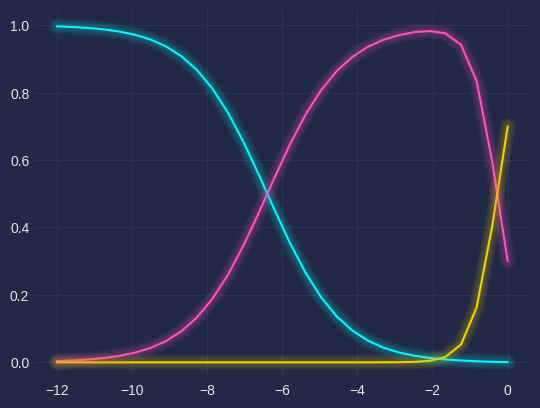

In [6]:
plt.plot(N,O[:,0])
plt.plot(N,O[:,1])
plt.plot(N,O[:,2])
mplcyberpunk.make_lines_glow()

---

## System of Ordinary Differential Equations
A number of coupled differential equations form a system of equations. Let $t \in \mathcal{R}$ 
be the independent variable and $$\bar{x}(t) : \mathcal{R}\longrightarrow \mathcal{R}^m$$
be a function of $t$. A system of ordinary differential equations of order $n$ takes the form:

$$F(t, \vec{x}, \frac{d\vec{x}}{dt}, \frac{d^2\vec{x}}{dt^2}, \ldots, \frac{d^n\vec{x}}{dt^n}) = \vec{0},
$$

\\


\\


$$
\begin{split}\begin{pmatrix}
f_0(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n}) \\
f_1(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n}) \\
\vdots \\
f_{m-1}(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n})
\end{pmatrix}
=
\begin{pmatrix}
0 \\
0 \\
\vdots \\
0
\end{pmatrix}\end{split}
$$

\begin{equation}

    \Omega_i' = 3(\Pi - \gamma_i)\Omega_i,
\end{equation}

con $\Pi = \sum_i \gamma_i \Omega_i$

$\Omega_r, \gamma_r = 4/3$

$\Omega_m, \gamma_m = 1$

$\Omega_\Lambda, \gamma_\Lambda = 0$



In [7]:
nodos=50
ANN = nn.Sequential(nn.Linear(2, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,3))
print(ANN)

Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=3, bias=True)
)


In [12]:
#The domain and the batch for the training
ti=-12.0
tf=0.0

Om_i=0.1
Om_f=0.5



T=torch.cartesian_prod(torch.linspace(ti,tf,100), torch.linspace(Om_i,Om_f,10))

In [13]:
if torch.cuda.is_available(): T.cuda()

In [14]:
T.shape

torch.Size([1000, 2])

In [15]:
# #reparam of the solution to meet the initial conditions
# init_conditions=torch.tensor([[0.0005,0.3,0.7]])

# def Param(t,x0=init_conditions,net=ANN):
#     #out = net(T)
#     #b=1-torch.exp(ti-T[:,0])
#     #return torch.reshape(T[:,1],out.size()) + b*out
#     #return T[:,1].view(-1,1) + a.view(-1,1) +b.view(-1,1)**2 * out
#     return x0 + (1.0-torch.exp(t))*net(t)
#     #return x0 + b.view(-1,1) * out}

\begin{equation}

    \Omega_i' = 3(\Pi - \gamma_i)\Omega_i,
\end{equation}

con $\Pi = \sum_i \gamma_i \Omega_i$

$\Omega_r, \gamma_r = 4/3$

$\Omega_m, \gamma_m = 1$

$\Omega_\Lambda, \gamma_\Lambda = 0$



In [18]:
g_r = 4.0/3.0
g_m = 1.0
g_l = 0.0

Ol0=0.7


def cost(t):
    t0=torch.tensor([[0.0]], requires_grad=True)

    Or=ANN(t)[:,0].view(-1,1)
    Om=ANN(t)[:,1].view(-1,1)
    Ol=ANN(t)[:,2].view(-1,1)

    D_Or = nth_derivative(ANN,t, 0, 0,1)
    D_Om = nth_derivative(ANN,t, 1, 0,1)
    D_Ol = nth_derivative(ANN,t, 2, 0,1)

    pi = g_l*Ol + g_r*Or + g_m*Om

    a=torch.mean((D_Ol - 3*(pi - g_l)*Ol )**2)
    b=torch.mean((D_Or - 3*(pi - g_r)*Or )**2)
    c=torch.mean((D_Om - 3*(pi - g_m)*Om )**2)


    x0 = ANN(t0) - torch.tensor([0.0005,0.3,0.7])
    
    return  a + b + c + torch.mean(x0**2) 

In [19]:
ANN(torch.tensor([0.0])) - torch.tensor([1.0,2.0,3.0])

tensor([-1.1401, -1.7780, -2.9731], grad_fn=<SubBackward0>)

In [20]:
cost(t)

tensor(4.0713, grad_fn=<AddBackward0>)

In [21]:
learning_rate=0.01
epocas=5000


optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)

In [22]:
#t.cuda()

Training:   0%|                                                | 0/5000 [00:00<?, ?it/s, loss=0.691]

Training: 100%|███████████████████████████████████| 5000/5000 [00:56<00:00, 88.57it/s, loss=8.96e-5]


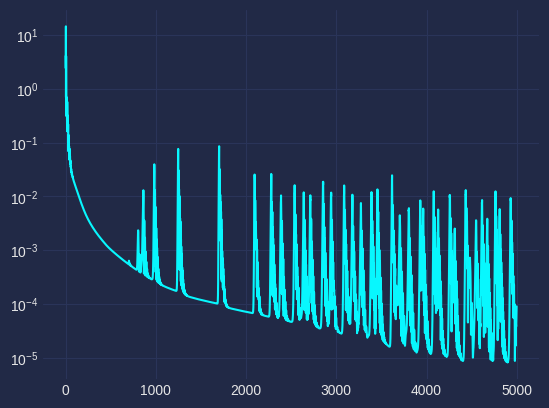

In [23]:
#loop de entrenamiendo 
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(t) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)
plt.yscale('log')

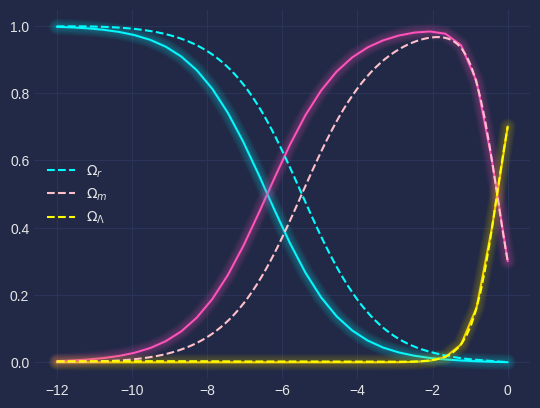

In [25]:
plt.plot(N,O[:,0])
plt.plot(N,O[:,1])
plt.plot(N,O[:,2])
mplcyberpunk.make_lines_glow()


plt.plot(t.detach(),ANN(t).detach()[:,0],'--', label='$\Omega_r$', color='cyan')
plt.plot(t.detach(),ANN(t).detach()[:,1], '--',label='$\Omega_m$', color='pink')
plt.plot(t.detach(),ANN(t).detach()[:,2], '--',label='$\Omega_\Lambda$', color='yellow')
plt.legend()
#plt.plot(t.detach(),1/3 * torch.exp(t.detach()) + 2/3*torch.exp(4.0*t.detach()))
         
#y(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t})

In [35]:
ANN(torch.tensor(([0.0])))

tensor([-9.5539e-05,  3.0126e-01,  7.0053e-01], grad_fn=<ViewBackward0>)

# Parámetros del modelo
a = 1.0
b = 1.0
c = 1.0
d = 1.0

# Ecuaciones de Lotka-Volterra
def dxdt(x, y):
  return a * x - b * x * y

def dydt(x, y):
  return c * x * y - d * y

# Solución numérica de las ecuaciones
t = np.linspace(0,26, 100)
x = np.zeros(len(t))
y = np.zeros(len(t))

x[0] = 1.5
y[0] = 1.0

for i in range(1, len(t)):
  x[i] = x[i - 1] + dxdt(x[i - 1], y[i - 1]) * (t[i] - t[i - 1])
  y[i] = y[i - 1] + dydt(x[i - 1], y[i - 1]) * (t[i] - t[i - 1])

# Gráfica de las poblaciones
plt.plot(t, x, label="Presa")
plt.plot(t, y, label="Depredador")
plt.xlabel("Tiempo")
plt.ylabel("Población")
plt.legend()
plt.show()